# When does upwelling start and end..?
Using modelled and observed alongshore flow, the Bakun index, and 2022 SOPO report by Hourston and Thompson

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import xarray as xr
from scipy import stats
from matplotlib.gridspec import GridSpec
from scipy.signal import windows


In [2]:
def calc_stats(x, y):
    stat = {}
    x_new = x[np.isfinite(x)]
    y_new = y[np.isfinite(x)]
    x = x_new[np.isfinite(y_new)]
    y = y_new[np.isfinite(y_new)]

    MSE = np.mean((y - x)**2)
    stat['RMSE'] = np.sqrt(MSE)
    stat['bias'] = np.mean(y) - np.mean(x)
    stat['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    stat['r'] = stats.pearsonr(x,y).statistic
    
    return stat

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}\nr = {stats['r']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.02, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

### Observed and modelled flow along the Washington Shelf

In [3]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ooi/ooi-ce07shsm_ns.p")

#change it to daily
df = df.set_index('datetime')
df = df.resample('D',axis=0).mean()
df['datetime'] = df.index
df['datetime'] = df.datetime.dt.tz_localize(None)
index = pd.Index(range(len(df)))
df.set_index(index,inplace=True)

# undo a conversion you did wrong while downloading
df['model_o'] = df['model_o']*1000
df['model_n'] = df['model_n']*1000

df.head()

/tmp/ipykernel_100792/586479787.py:5: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  df = df.resample('D',axis=0).mean()


,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (decibars),sea_water_density (kg.m-3),sea_water_temperature (degree_Celsius),sea_water_practical_salinity (1e-3),eastward_sea_water_velocity (m.s-1),northward_sea_water_velocity (m.s-1),upward_sea_water_velocity (m.s-1),mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water_full (micromol.L-1),model_s,model_t,model_o,model_n,model_u,model_v,model_w,datetime
0,-124.56771,46.98805,6.854692,1022.847750,11.576610,30.034466,-0.117203,0.105899,-0.003214,328.064508,2.382661,NaN,32.049187,11.342179,292748.753139,3699.383514,0.060074,-0.150205,-0.000438,2015-04-05
1,-124.56771,46.98805,6.999410,1022.709479,11.855760,29.919234,-0.072239,0.012859,0.012250,327.080932,1.737885,NaN,32.043394,11.200430,303958.724976,2849.506820,0.007874,-0.154421,0.000132,2015-04-06
2,-124.56771,46.98805,6.984690,1022.692406,11.871754,29.900849,-0.005883,-0.068618,0.023058,328.092859,1.653027,NaN,31.978598,11.138652,305924.210866,3358.608812,0.022341,-0.101412,-0.000099,2015-04-07
3,-124.56771,46.98805,7.086526,1021.992800,11.894292,29.003054,0.002292,-0.023756,0.021859,332.698058,2.136899,NaN,31.927282,11.167915,311147.148132,2822.140145,-0.006459,-0.102180,-0.000057,2015-04-08
4,-124.56771,46.98805,7.166901,1023.409156,11.902085,30.830995,-0.010126,-0.118461,0.007072,325.987637,1.218262,NaN,31.980176,11.216674,316177.506765,2101.774228,-0.050276,-0.133598,0.000003,2015-04-09


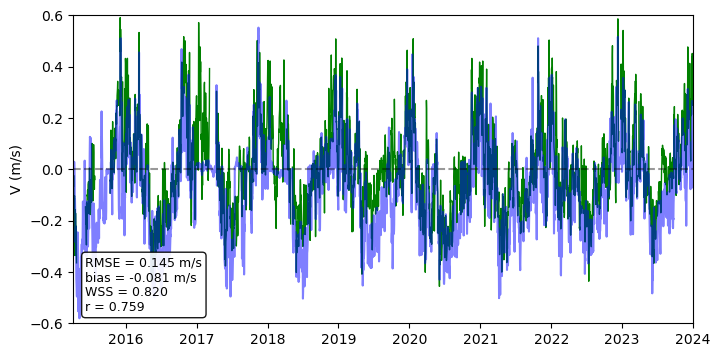

In [4]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax.plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax.set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax, df['northward_sea_water_velocity (m.s-1)'], df['model_v'], (-0.1,0.1), 'm/s')


ax.set_ylim([-0.6,0.6])
ax.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])
ax.plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

# for j in range(0, len(season),2):
    # ax.fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

In [5]:
window_size = 15  # 15 day running mean based on smoothing from Foreman et al., 2011 - Trends in upwelling and downwelling winds along the BritishColumbia shelf
df['smoothed_obs_v'] = df['northward_sea_water_velocity (m.s-1)'].rolling(window=window_size).mean()
df['smoothed_mod_v'] = df['model_v'].rolling(window=window_size).mean()

In [6]:
# spring and fall transition in observations:
obs_dates = np.array([dt.datetime(2015,3,4),dt.datetime(2015,10,6),
                      dt.datetime(2016,5,4),dt.datetime(2016,10,1),
                      dt.datetime(2017,5,4),dt.datetime(2017,10,22),
                      dt.datetime(2018,5,1),dt.datetime(2018,10,4),
                      dt.datetime(2019,4,28),dt.datetime(2019,9,20),
                      dt.datetime(2020,2,15),dt.datetime(2020,11,12),
                      dt.datetime(2021,3,27),dt.datetime(2021,10,1),
                      dt.datetime(2022,2,10),dt.datetime(2022,9,30),
                      dt.datetime(2023,5,5),dt.datetime(2023,9,5)])

mod_dates = np.array([dt.datetime(2015,3,4),dt.datetime(2015,10,22),
                      dt.datetime(2016,4,5),dt.datetime(2016,10,1),
                      dt.datetime(2017,5,6),dt.datetime(2017,10,30),
                      dt.datetime(2018,5,1),dt.datetime(2018,10,25),
                      dt.datetime(2019,4,26),dt.datetime(2019,12,5),
                      dt.datetime(2020,2,12),dt.datetime(2020,11,12),
                      dt.datetime(2021,3,17),dt.datetime(2021,10,7),
                      dt.datetime(2022,1,25),dt.datetime(2022,10,5),
                      dt.datetime(2023,5,5),dt.datetime(2023,9,30)])


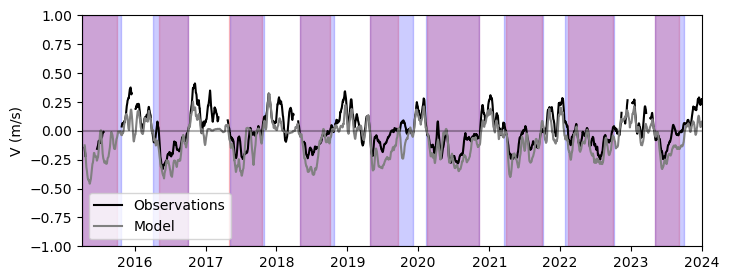

In [7]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.datetime, df['smoothed_obs_v'],'k',label='Observations')
ax.plot(df.datetime, df['smoothed_mod_v'],'gray',label='Model')

ax.set_ylabel('V (m/s)')
ax.set_ylim([-1,1])
ax.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k',alpha=0.3)
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])
ax.plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

ax.legend(loc="lower left")

for j in range(0, len(mod_dates),2):
    ax.fill_between(df.datetime, -1, 1, where=(df.datetime<obs_dates[j+1])&(df.datetime>=obs_dates[j]), color='r', alpha=0.2)
    ax.fill_between(df.datetime, -1, 1, where=(df.datetime<mod_dates[j+1])&(df.datetime>=mod_dates[j]), color='b', alpha=0.2)


### Same timeseries compared to Hourston and Thompson SOPO report

In [8]:
# from https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41199248.pdf chapter 8
ht_dates = np.array([dt.datetime(2013,1,19),dt.datetime(2013,10,25),
                      dt.datetime(2014,3,4),dt.datetime(2014,9,15),
                      dt.datetime(2015,3,13),dt.datetime(2015,9,3),
                      dt.datetime(2016,3,21),dt.datetime(2016,9,13),
                      dt.datetime(2017,4,23),dt.datetime(2017,10,16),
                      dt.datetime(2018,2,11),dt.datetime(2018,9,9),
                      dt.datetime(2019,4,8),dt.datetime(2019,11,3),
                      dt.datetime(2020,2,4),dt.datetime(2020,10,15),
                      dt.datetime(2021,2,2),dt.datetime(2021,9,27),
                      dt.datetime(2022,6,10),dt.datetime(2022,10,23)])

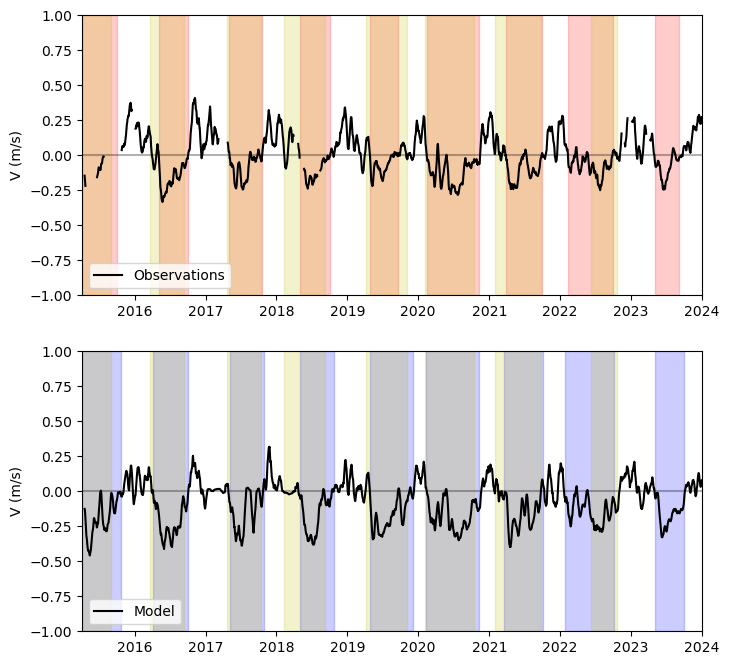

In [9]:
fig,ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(df.datetime, df['smoothed_obs_v'],'k',label='Observations')
ax[1].plot(df.datetime, df['smoothed_mod_v'],'k',label='Model')

for axs in ax:
    axs.set_ylabel('V (m/s)')
    axs.set_ylim([-1,1])
    axs.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k',alpha=0.3)
    axs.set_xlim([np.min(df.datetime),np.max(df.datetime)])
    axs.legend(loc="lower left")

for j in range(0, len(obs_dates),2):
    ax[0].fill_between(df.datetime, -1, 1, where=(df.datetime<obs_dates[j+1])&(df.datetime>=obs_dates[j]), color='r', alpha=0.2)
    ax[1].fill_between(df.datetime, -1, 1, where=(df.datetime<mod_dates[j+1])&(df.datetime>=mod_dates[j]), color='b', alpha=0.2)
for j in range(0, len(ht_dates),2):
    ax[0].fill_between(df.datetime, -1, 1, where=(df.datetime<ht_dates[j+1])&(df.datetime>=ht_dates[j]), color='y', alpha=0.2)
    ax[1].fill_between(df.datetime, -1, 1, where=(df.datetime<ht_dates[j+1])&(df.datetime>=ht_dates[j]), color='y', alpha=0.2)


what if i defined the "buffer" as the region of time where upwelling index in observations (from Hourston and Thomspson) dont overlap instead of a set number of days?

### And now looking at the CUTI index
available from https://mjacox.com/upwelling-indices/

In [10]:
cuti = xr.open_dataset('/data1/bbeutel/LO_user/CUTI_daily.nc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


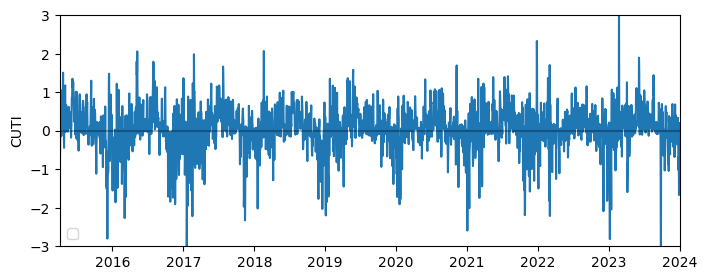

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(cuti.time, cuti.CUTI[:,-1])

ax.set_ylabel('CUTI')
ax.set_ylim([-3,3])
ax.plot([np.datetime64(np.min(df.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(df.datetime)),np.datetime64(np.max(df.datetime))])
ax.legend(loc="lower left")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-800.0, 50.0)

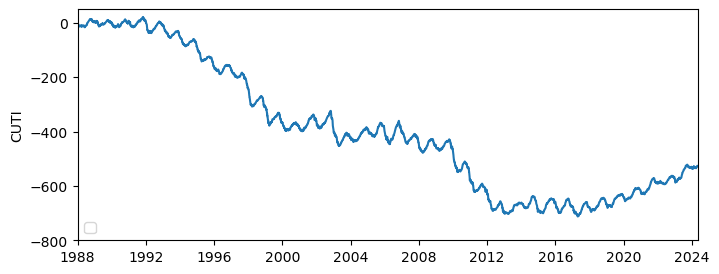

In [12]:
cummulative = np.cumsum(cuti.CUTI[:,-1].values)

fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(cuti.time, cummulative)

ax.set_ylabel('CUTI')
ax.legend(loc="lower left")
ax.set_xlim([np.min(cuti.time),np.max(cuti.time)])
ax.set_ylim([-800,50])

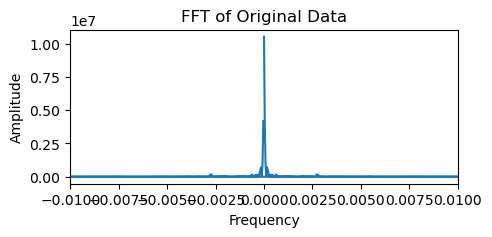

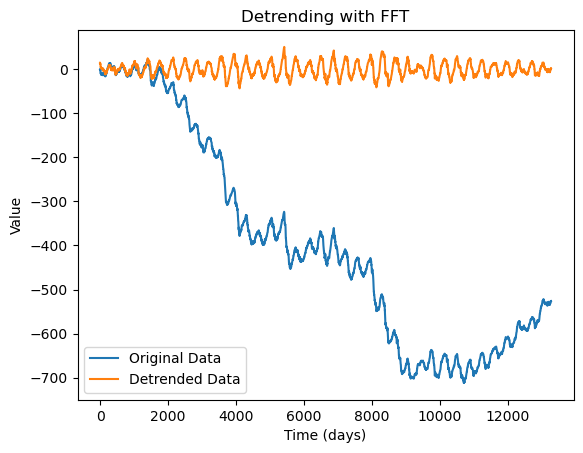

In [13]:
# we only want the seasonal cycle, so remove the multiyear trend
data = np.asarray(cummulative)
time = np.asarray(cuti.time.values)
time_numeric = (time - time[0]) / np.timedelta64(1, 'D')  # Convert to days

# Detrend using Fourier transform
n = len(data) 
pad_length = n // 2  # Add half the data length as padding
data_padded = np.pad(data, pad_width=(pad_length, pad_length), mode='reflect')
fft_data = np.fft.fft(data_padded)  # Perform FFT
frequencies = np.fft.fftfreq(len(fft_data), d=(time_numeric[1] - time_numeric[0]))  # Compute frequencies

# original data in frequency domain
plt.figure(figsize=[5,2])
plt.plot(frequencies, np.abs(fft_data))
plt.xlim([-0.01,0.01])
plt.title("FFT of Original Data")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

# Identify and remove low-frequency components
low_freq_threshold = 1 / 500
fft_data[np.abs(frequencies) < low_freq_threshold] = 0

# Apply inverse FFT to get detrended data
detrended_padded = np.fft.ifft(fft_data).real
detrended_data = detrended_padded[pad_length:-pad_length]  # Remove padding

# Plot detrended data
plt.figure()
plt.plot(time_numeric, data, label="Original Data")
plt.plot(time_numeric, detrended_data, label="Detrended Data")
plt.title("Detrending with FFT")
plt.xlabel("Time (days)")
plt.ylabel("Value")
plt.legend()
# plt.ylim([100,-100])
plt.show()

In [14]:
# come up with a function to identify the spring transition (slope switches from negative to positive)
# and fall transition (slope switches from positive to negative)
# possible to simply use the min (spring transition) and max (fall transition) from each year?
spring = np.empty(len(set(cuti.year.values)),dtype='datetime64[ns]')
fall = np.empty(len(set(cuti.year.values)),dtype='datetime64[ns]')
i=0
for year in set(cuti.year.values):
    cum = detrended_data[cuti.year.values == year]
    dates = cuti.time.values[cuti.year.values == year]

    indmax = np.argmax(cum)
    indmin = np.argmin(cum)

    fall[i] =dates[indmax]
    spring[i] =dates[indmin]
    i+=1


In [15]:
# remove dates if there wasn't enough dataset to capture them
fall = fall[1:-1]
spring = spring[:-1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


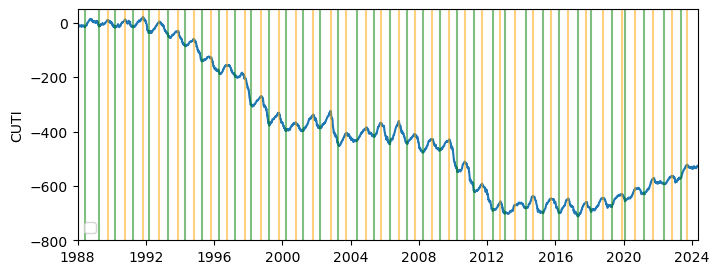

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(cuti.time, cummulative)

ax.set_ylabel('CUTI')
ax.legend(loc="lower left")
ax.set_xlim([np.min(cuti.time),np.max(cuti.time)])
ax.set_ylim([-800,50])

# plot spring and fall transition
for i in range(len(fall)):
    ax.plot([fall[i],fall[i]],[-800,50],c='orange',alpha=0.5)
for i in range(len(spring)):
    ax.plot([spring[i],spring[i]],[-800,50],c='green',alpha=0.5)


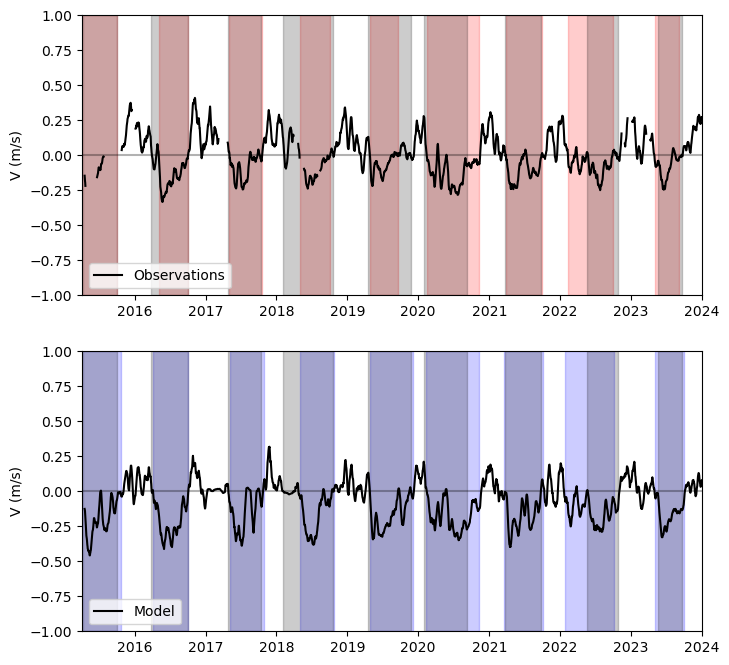

In [17]:
fig,ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(df.datetime, df['smoothed_obs_v'],'k',label='Observations')
ax[1].plot(df.datetime, df['smoothed_mod_v'],'k',label='Model')

for axs in ax:
    axs.set_ylabel('V (m/s)')
    axs.set_ylim([-1,1])
    axs.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k',alpha=0.3)
    axs.set_xlim([np.min(df.datetime),np.max(df.datetime)])
    axs.legend(loc="lower left")

for j in range(0, len(obs_dates),2):
    ax[0].fill_between(df.datetime, -1, 1, where=(df.datetime<obs_dates[j+1])&(df.datetime>=obs_dates[j]), color='r', alpha=0.2)
    ax[1].fill_between(df.datetime, -1, 1, where=(df.datetime<mod_dates[j+1])&(df.datetime>=mod_dates[j]), color='b', alpha=0.2)
for j in range(len(fall[24:])):
    ax[0].fill_between(df.datetime, -1, 1, where=(df.datetime<fall[24+j])&(df.datetime>=spring[25+j]), color='k', alpha=0.2)
    ax[1].fill_between(df.datetime, -1, 1, where=(df.datetime<fall[24+j])&(df.datetime>=spring[25+j]), color='k', alpha=0.2)

In [18]:
# bring in monthly
cuti_mo = xr.open_dataset('/data1/bbeutel/LO_user/CUTI_monthly.nc')

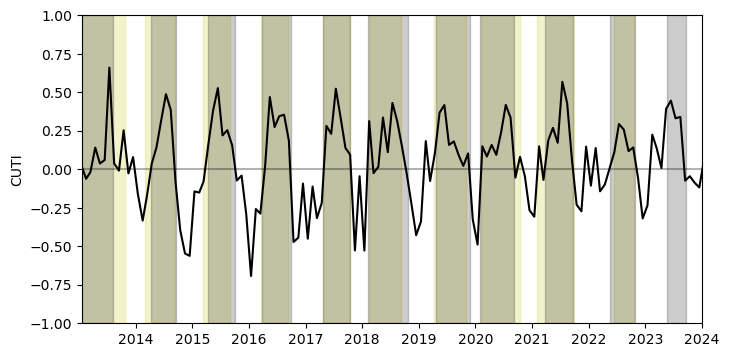

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(cuti_mo.time, cuti_mo.CUTI[:,-1],'k')

ax.set_ylabel('CUTI')
ax.set_ylim([-1,1])
ax.plot([np.datetime64(np.min(ht_dates)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(ht_dates)),np.datetime64(np.max(df.datetime))])

for j in range(0, len(ht_dates),2):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<ht_dates[j+1])&(pd.to_datetime(cuti.time.values)>=ht_dates[j]), color='y', alpha=0.2)
for j in range(len(fall[24:])):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<fall[24+j])&(pd.to_datetime(cuti.time.values)>=spring[25+j]), color='k', alpha=0.2)

## try Bakun index too
available from https://oceanview.pfeg.noaa.gov/products/upwelling/dnld

In [20]:
bakun = pd.read_csv('/data1/bbeutel/LO_user/Bakun.txt', sep="\s+", header=5)
bakun['date'] = pd.to_datetime(bakun.YYYYMMDD, format='%Y%m%d', errors='coerce')
bakun = bakun.sort_values(by='date')
# drop values greater than -500
bakun.loc[bakun.Index<=-500, "Index"] = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-1096.0, 20088.0)

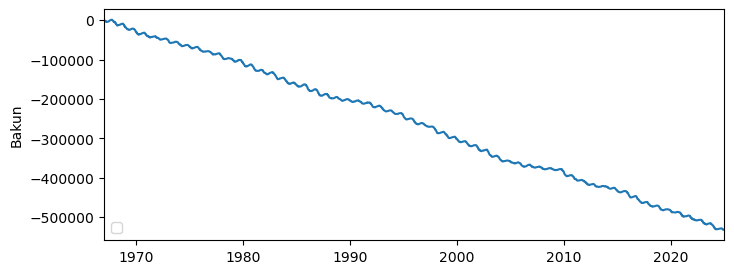

In [21]:
cummulative = np.cumsum(bakun.Index)

fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(bakun.date, cummulative)

ax.set_ylabel('Bakun')
ax.legend(loc="lower left")
ax.set_xlim([np.min(bakun.date),np.max(bakun.date)])

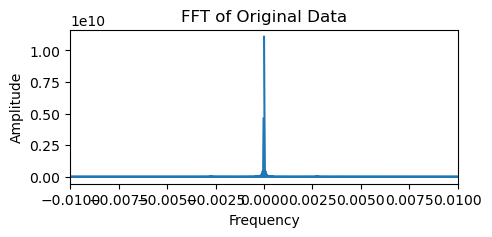

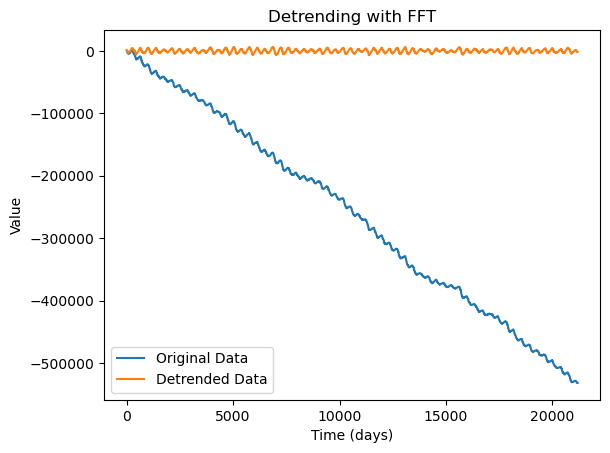

In [22]:
# we only want the seasonal cycle, so remove the multiyear trend
data = np.asarray(cummulative)
time = np.asarray(bakun.date)
time_numeric = (time - time[0]) / np.timedelta64(1, 'D')  # Convert to days

# Detrend using Fourier transform
n = len(data) 
pad_length = n // 2  # Add half the data length as padding
data_padded = np.pad(data, pad_width=(pad_length, pad_length), mode='reflect')
fft_data = np.fft.fft(data_padded)  # Perform FFT
frequencies = np.fft.fftfreq(len(fft_data), d=(time_numeric[1] - time_numeric[0]))  # Compute frequencies

# original data in frequency domain
plt.figure(figsize=[5,2])
plt.plot(frequencies, np.abs(fft_data))
plt.xlim([-0.01,0.01])
plt.title("FFT of Original Data")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

# Identify and remove low-frequency components
low_freq_threshold = 1 / 1000
fft_data[np.abs(frequencies) < low_freq_threshold] = 0

# Apply inverse FFT to get detrended data
detrended_padded = np.fft.ifft(fft_data).real
detrended_data = detrended_padded[pad_length:-pad_length]  # Remove padding

# Plot detrended data
plt.figure()
plt.plot(time_numeric, data, label="Original Data")
plt.plot(time_numeric, detrended_data, label="Detrended Data")
plt.title("Detrending with FFT")
plt.xlabel("Time (days)")
plt.ylabel("Value")
plt.legend()
# plt.ylim([100,-100])
plt.show()

In [23]:
# come up with a function to identify the spring transition (slope switches from negative to positive)
# and fall transition (slope switches from positive to negative)
# possible to simply use the min (spring transition) and max (fall transition) from each year?
bakun['year'] = [bakun.date[i].year for i in range(len(bakun))]

spring = np.empty(len(set(bakun.year)),dtype='datetime64[ns]')
fall = np.empty(len(set(bakun.year)),dtype='datetime64[ns]')
i=0
for year in set(bakun.year):
    cum = detrended_data[bakun.year == year]
    dates = bakun.date[bakun.year == year].reset_index()

    indmax = np.argmax(cum)
    indmin = np.argmin(cum)

    fall[i] =dates.date[indmax]
    spring[i] =dates.date[indmin]
    i+=1

In [24]:
fall = fall[:-1]
spring = spring[:-1]
spring[47] = np.datetime64('2014-03-20T00:00:00.000000000') # fix this year manually

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


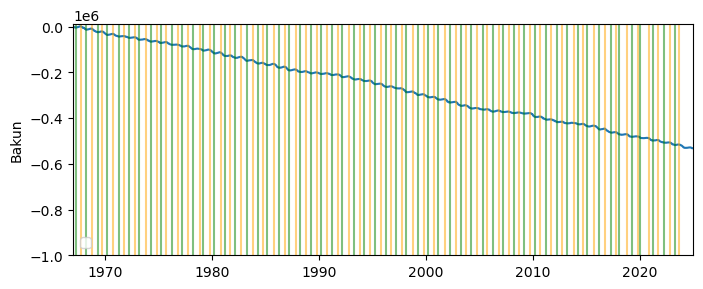

In [25]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(bakun.date, cummulative)

ax.set_ylabel('Bakun')
ax.legend(loc="lower left")
ax.set_xlim([np.min(bakun.date),np.max(bakun.date)])
ax.set_ylim([-1000000,10000])

# plot spring and fall transition
for i in range(len(fall)):
    ax.plot([fall[i],fall[i]],[-1000000,10000],c='orange',alpha=0.5)
for i in range(len(spring)):
    ax.plot([spring[i],spring[i]],[-1000000,10000],c='green',alpha=0.5)


In [26]:
window_size = 15  # 15 day running mean based on smoothing from Foreman et al., 2011 - Trends in upwelling and downwelling winds along the BritishColumbia shelf
bakun['smoothed'] = bakun['Index'].rolling(window=window_size).mean()

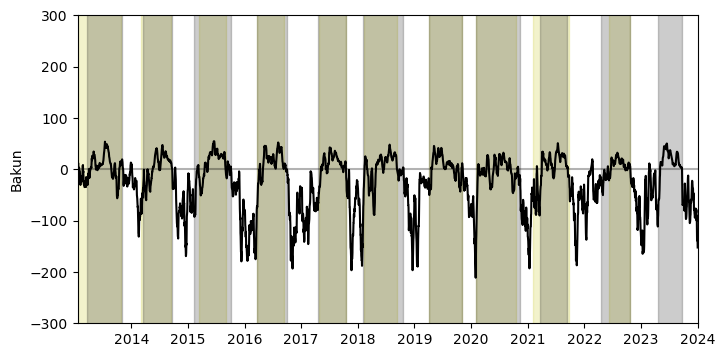

In [27]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(bakun.date, bakun.smoothed,'k')

ax.set_ylabel('Bakun')
ax.set_ylim([-300,300])
ax.plot([np.datetime64(np.min(ht_dates)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(ht_dates)),np.datetime64(np.max(df.datetime))])

for j in range(0, len(ht_dates),2):
    ax.fill_between(pd.to_datetime(bakun.date), -500, 500, where=(pd.to_datetime(bakun.date)<ht_dates[j+1])&(pd.to_datetime(bakun.date)>=ht_dates[j]), color='y', alpha=0.2)
for j in range(len(fall[46:])):
    ax.fill_between(pd.to_datetime(bakun.date), -500, 500, where=(pd.to_datetime(bakun.date)<fall[46+j])&(pd.to_datetime(bakun.date)>=spring[46+j]), color='k', alpha=0.2)

agrees pretty well with Hourston and Thompson 2022

## can we get more years from a different mooring?
#### Hourston and Thomson use mooring A1 from the DFO, which i already have downloaded 

In [28]:
a1 = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/ios/-126.284163_48.681239999999995_cur.p')

#change it to daily
a1 = a1.set_index('datetime')
a1 = a1.resample('D',axis=0).mean()
a1['datetime'] = a1.index
a1['datetime'] = a1.datetime.dt.tz_localize(None)
index = pd.Index(range(len(a1)))
a1.set_index(index,inplace=True)

a1
# note that the intrument depth varies with time.. model cell changes accordingly so hopefully that OKAY for upwelling analysis

/tmp/ipykernel_100792/3793850695.py:5: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  a1 = a1.resample('D',axis=0).mean()


,longitude (degrees_east),latitude (degrees_north),instrument_depth (m),PRESPR01 (decibar),LCEWEL01 (m/s),LCNSEL01 (m/s),LRZASP01 (m/s),model_u,model_v,model_w,datetime
0,-126.284163,48.681240,64.2,66.509554,-0.040537,0.010483,-0.003821,-0.030805,0.103854,-0.000173,2012-12-31
1,-126.284163,48.681240,64.2,66.532921,-0.084754,0.052937,0.000625,-0.027154,0.101727,-0.000094,2013-01-01
2,-126.284163,48.681240,64.2,66.546450,-0.113279,-0.041454,-0.000717,-0.040478,0.088958,-0.000038,2013-01-02
3,-126.284163,48.681240,64.2,66.551992,-0.089562,-0.055850,-0.001667,-0.052803,0.015156,-0.000006,2013-01-03
4,-126.284163,48.681240,64.2,66.563012,-0.115933,0.021521,-0.009929,-0.047932,0.056577,-0.000063,2013-01-04
...,...,...,...,...,...,...,...,...,...,...,...
2399,-126.184330,48.548668,204.0,NaN,-0.009826,-0.021007,-0.008090,0.086205,-0.131597,-0.000104,2019-07-27
2400,-126.184330,48.548668,204.0,NaN,0.015271,-0.045924,0.003819,0.085184,-0.151474,-0.000461,2019-07-28
2401,-126.184330,48.548668,204.0,NaN,-0.071750,-0.043153,0.010910,0.097996,-0.161163,-0.000397,2019-07-29
2402,-126.184330,48.548668,204.0,NaN,-0.050181,-0.052167,0.004479,0.089534,-0.174777,-0.000615,2019-07-30


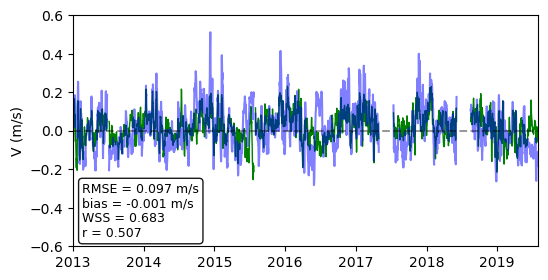

In [29]:
fig,ax = plt.subplots(1,1,figsize=(6,3))

ax.plot(a1.datetime, a1['LCNSEL01 (m/s)'],'g',lw=1,label='Observations')
ax.plot(a1.datetime, a1['model_v'],'b',label='Model',alpha=0.5)
ax.set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax, a1['LCNSEL01 (m/s)'], a1['model_v'], (-0.1,0.1), 'm/s')


ax.set_ylim([-0.6,0.6])
ax.plot([np.min(a1.datetime),np.max(a1.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(a1.datetime),np.max(a1.datetime)])
ax.plot([np.min(a1.index),np.max(a1.index)],[0,0],'k--',alpha=0.6)


In [30]:
# rotate both such that the wind magnitude toward 325 deg

# Define the direction in degrees (used same as Hourston and Thomson)
direction_degrees = 325

# Convert the direction to radians
direction_radians = np.deg2rad(direction_degrees)

# Calculate the wind magnitude towards the specified direction
# and smooth it
window_size= 15
a1['model_325'] = (a1['model_u'] * np.cos(direction_radians) + a1['model_v'] * np.sin(direction_radians)).rolling(window=window_size).mean()
a1['obs_325'] = (a1['LCEWEL01 (m/s)'] * np.cos(direction_radians) + a1['LCNSEL01 (m/s)'] * np.sin(direction_radians)).rolling(window=window_size).mean()

In [31]:
ht_dates = np.array([dt.datetime(2013,1,19),dt.datetime(2013,10,25),
                      dt.datetime(2014,3,4),dt.datetime(2014,9,15),
                      dt.datetime(2015,3,13),dt.datetime(2015,9,3),
                      dt.datetime(2016,3,21),dt.datetime(2016,9,13),
                      dt.datetime(2017,4,23),dt.datetime(2017,10,16),
                      dt.datetime(2018,2,11),dt.datetime(2018,9,9),
                      dt.datetime(2019,4,8),dt.datetime(2019,11,3),
                      dt.datetime(2020,2,4),dt.datetime(2020,10,15),
                      dt.datetime(2021,2,2),dt.datetime(2021,9,27),
                      dt.datetime(2022,6,10),dt.datetime(2022,10,23)])

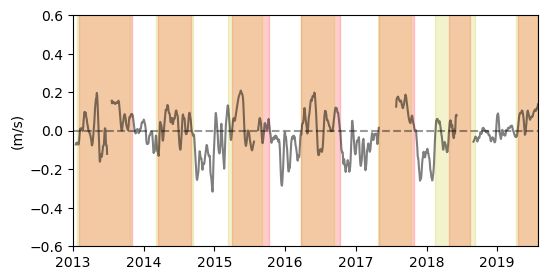

In [32]:
a1_up = np.array([dt.datetime(2013,2,1),dt.datetime(2013,11,3),
               dt.datetime(2014,3,13),dt.datetime(2014,9,3),
               dt.datetime(2015,4,1),dt.datetime(2015,10,13),
               dt.datetime(2016,3,25),dt.datetime(2016,10,13),
               dt.datetime(2017,5,2),dt.datetime(2017,10,29),
               dt.datetime(2018,4,25),dt.datetime(2018,8,15),
               dt.datetime(2019,4,16),dt.datetime(2019,11,3)])

fig,ax = plt.subplots(1,1,figsize=(6,3))

# ax.plot(a1.datetime, a1['obs_325'],'k',lw=1,label='Observations')
ax.plot(a1.datetime, a1['model_325'],'k',label='Model',alpha=0.5)
ax.set_ylabel('(m/s)')
# plot the stats pannel
# plot_panel(ax, a1['obs_325'], a1['model_325'], (-0.1,0.1), 'm/s')

ax.set_ylim([-0.6,0.6])
ax.plot([np.min(a1.datetime),np.max(a1.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(a1.datetime),np.max(a1.datetime)])
ax.plot([np.min(a1.index),np.max(a1.index)],[0,0],'k--',alpha=0.6)

for j in range(0, len(a1_up),2):
    ax.fill_between(a1.datetime, -1, 1, where=(a1.datetime<a1_up[j+1])&(a1.datetime>=a1_up[j]), color='r', alpha=0.2)
for j in range(0, len(ht_dates),2):
    ax.fill_between(a1.datetime, -1, 1, where=(a1.datetime<ht_dates[j+1])&(a1.datetime>=ht_dates[j]), color='y', alpha=0.2)

# Final upwelling and downwelling dates with min 20 d buffer between

In [33]:
up = np.array([dt.datetime(2013,3,19),dt.datetime(2013,10,24),
               dt.datetime(2014,3,27),dt.datetime(2014,9,2),
               dt.datetime(2015,4,1),dt.datetime(2015,10,4),
               dt.datetime(2016,4,9),dt.datetime(2016,9,27),
               dt.datetime(2017,5,6),dt.datetime(2017,10,12),
               dt.datetime(2018,5,1),dt.datetime(2018,10,13),
               dt.datetime(2019,4,26),dt.datetime(2019,11,3),
               dt.datetime(2020,2,16),dt.datetime(2020,10,23),
               dt.datetime(2021,3,17),dt.datetime(2021,9,22),
               dt.datetime(2022,6,10),dt.datetime(2022,10,5),
               dt.datetime(2023,5,9),dt.datetime(2023,9,22)])

down = np.array([dt.datetime(2013,11,13),dt.datetime(2014,3,6),
                 dt.datetime(2014,9,23),dt.datetime(2015,2,12),
                 dt.datetime(2015,10,24),dt.datetime(2016,3,19),
                 dt.datetime(2016,10,17),dt.datetime(2017,4,2),
                 dt.datetime(2017,11,2),dt.datetime(2018,2,1),
                 dt.datetime(2018,11,3),dt.datetime(2019,4,6),
                 dt.datetime(2019,12,5),dt.datetime(2020,1,27),
                 dt.datetime(2020,11,12),dt.datetime(2021,2,2),
                 dt.datetime(2021,10,12),dt.datetime(2022,1,25),
                 dt.datetime(2022,10,25),dt.datetime(2023,4,18)])  

In [34]:
# how long are each of the buffers?
up[1:-1] - down

array([datetime.timedelta(days=-20), datetime.timedelta(days=21),
       datetime.timedelta(days=-21), datetime.timedelta(days=48),
       datetime.timedelta(days=-20), datetime.timedelta(days=21),
       datetime.timedelta(days=-20), datetime.timedelta(days=34),
       datetime.timedelta(days=-21), datetime.timedelta(days=89),
       datetime.timedelta(days=-21), datetime.timedelta(days=20),
       datetime.timedelta(days=-32), datetime.timedelta(days=20),
       datetime.timedelta(days=-20), datetime.timedelta(days=43),
       datetime.timedelta(days=-20), datetime.timedelta(days=136),
       datetime.timedelta(days=-20), datetime.timedelta(days=21)],
      dtype=object)

In [35]:
# downwelling season length 
down[1:][::2]-down[:-1][::2]

array([datetime.timedelta(days=113), datetime.timedelta(days=142),
       datetime.timedelta(days=147), datetime.timedelta(days=167),
       datetime.timedelta(days=91), datetime.timedelta(days=154),
       datetime.timedelta(days=53), datetime.timedelta(days=82),
       datetime.timedelta(days=105), datetime.timedelta(days=175)],
      dtype=object)

In [36]:
# upwelling season length 
up[1:][::2]-up[:-1][::2]

array([datetime.timedelta(days=219), datetime.timedelta(days=159),
       datetime.timedelta(days=186), datetime.timedelta(days=171),
       datetime.timedelta(days=159), datetime.timedelta(days=165),
       datetime.timedelta(days=191), datetime.timedelta(days=250),
       datetime.timedelta(days=189), datetime.timedelta(days=117),
       datetime.timedelta(days=136)], dtype=object)

In [37]:
alt_up = np.array([dt.datetime(2021,3,17), dt.datetime(2021,9,22), dt.datetime(2022,6,10),dt.datetime(2022,10,5)])
alt_down = np.array([dt.datetime(2020,11,12), dt.datetime(2021,2,2), dt.datetime(2021,10,12),dt.datetime(2022,1,25)])

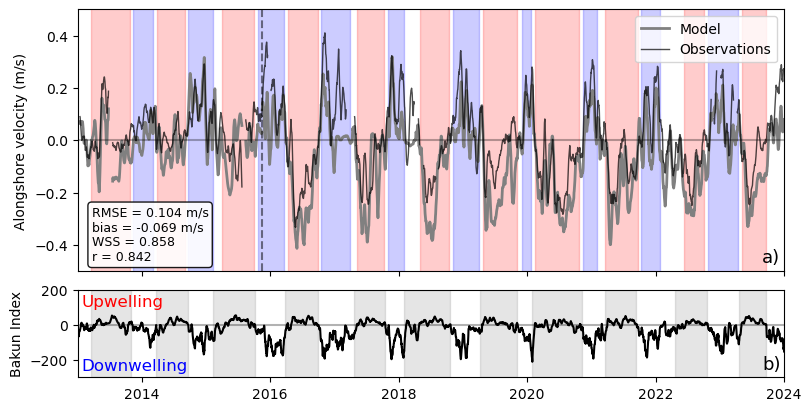

In [40]:
# update this figure once you have all the model output and this years SOPO

fig = plt.figure(constrained_layout=True, figsize=[8,4])
gs = GridSpec(4, 1, figure=fig)
ax = fig.add_subplot(gs[:3,0])
ax1 = fig.add_subplot(gs[3,0])

ax.set_ylabel('Alongshore velocity (m/s)')
ax.set_ylim([-0.5,0.5])
ax.plot(df.datetime[225:], df['smoothed_mod_v'][225:],'gray',lw=2,label='Model')
ax.plot(df.datetime[225:], df['smoothed_obs_v'][225:],'k',lw=1,label='Observations',alpha=0.7)

ax.plot(a1.datetime[:1050], a1['model_325'][:1050]*-1,'gray',lw=2)
ax.plot(a1.datetime[:1050], a1['obs_325'][:1050]*-1,'k',lw=1,alpha=0.7)

plot_panel(ax, np.append(a1['obs_325'][:1050]*-1,df['smoothed_obs_v'][225:]), np.append(a1['model_325'][:1050]*-1,df['smoothed_mod_v'][225:]), (-0.5,0.5), 'm/s')

ax.plot([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.plot([df.datetime[225],df.datetime[225]],[-0.5,0.5],'k--',alpha=0.5)
ax.set_xlim([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))])
ax.set_xticklabels([])
ax.legend()

# bakun
ax1.plot(bakun.date, bakun.smoothed,'k',label="Bakun Index")
ax1.set_ylabel('Bakun Index')
ax1.set_ylim([-300,200])
ax1.plot([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax1.set_xlim([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))])

# text
ax.text(.995, .02, 'a)', color='k', ha='right', va='bottom', transform=ax.transAxes, fontsize=13)
ax1.text(.995, 0.05, 'b)', color='k', ha='right', va='bottom', transform=ax1.transAxes, fontsize=13)
ax1.text(.005, 0.95, 'Upwelling', color='r', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax1.text(.005, 0.05, 'Downwelling', color='b', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)

for j in range(0, len(up),2):
    ax.fill_between(pd.to_datetime(bakun.date), -1, 1, where=(pd.to_datetime(bakun.date)<up[j+1])&(pd.to_datetime(bakun.date)>=up[j]), color='r', alpha=0.2,zorder=0)
for j in range(0, len(down),2):
    ax.fill_between(pd.to_datetime(bakun.date), -1, 1, where=(pd.to_datetime(bakun.date)<down[j+1])&(pd.to_datetime(bakun.date)>=down[j]), color='b', alpha=0.2,zorder=0)
for j in range(len(fall[46:])):
    ax1.fill_between(pd.to_datetime(bakun.date), -300, 200, where=(pd.to_datetime(bakun.date)<fall[46+j])&(pd.to_datetime(bakun.date)>=spring[46+j]), color='k', alpha=0.1)

plt.savefig('/data1/bbeutel/LO_user/ariane/figures/seasontiming.pdf')